In [1]:
import matplotlib.pyplot as plt
from src.dataset import ADE20KDataset, WallADE20KDataset, SimpleWallADE20KDataset
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader

In [2]:
DATA_ROOT = "../dataset/ADE20K_2021_17_01"

In [3]:
dataset = ADE20KDataset(DATA_ROOT)

In [4]:
image, mask = dataset[0]

In [5]:
image.shape, image.dtype

((1536, 2048, 3), dtype('uint8'))

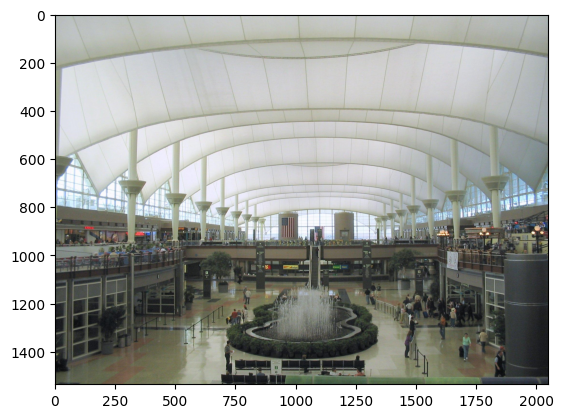

In [6]:
plt.imshow(image);

In [7]:
mask.shape, mask.dtype

((1536, 2048), dtype('float32'))

In [8]:
print(f"Unique mask labels: {len(np.unique(mask))}")

Unique mask labels: 20


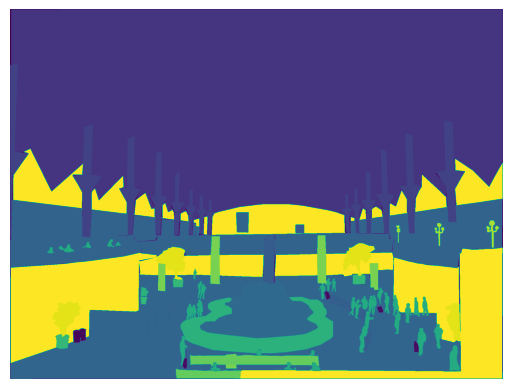

In [9]:
plt.imshow(mask)
plt.axis('off');

In [10]:
simple_wall_dataset = SimpleWallADE20KDataset(DATA_ROOT)

In [11]:
image, mask = simple_wall_dataset[0]
type(image), type(mask)

(numpy.ndarray, numpy.ndarray)

In [12]:
image.dtype, image.shape

(dtype('uint8'), (3, 512, 512))

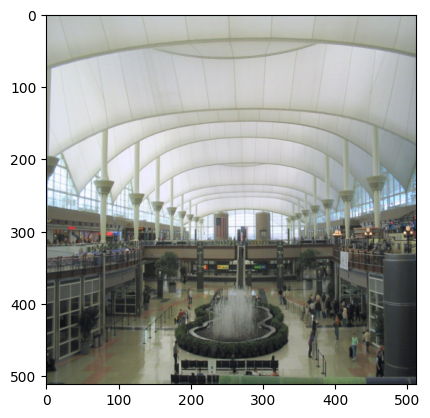

In [13]:
plt.imshow(image.transpose((1, 2, 0)));

In [14]:
wall_dataset = WallADE20KDataset(DATA_ROOT)

In [15]:
image, mask = wall_dataset[0]

In [16]:
mask.shape, mask.dtype, np.unique(mask)

((1536, 2048), dtype('float32'), array([0., 1.], dtype=float32))

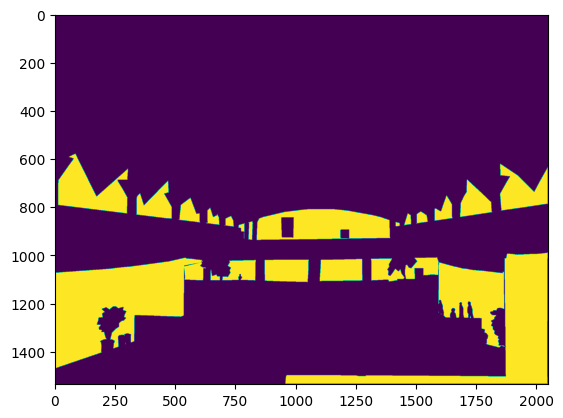

In [17]:
plt.imshow(mask);

In [34]:
train_dataloader = DataLoader(simple_wall_dataset, batch_size=3, shuffle=True, num_workers=1)

In [36]:
sample = next(iter(train_dataloader))

In [37]:
sample[0].dtype, sample[1].dtype

(torch.uint8, torch.float32)

In [38]:
sample[0].shape, sample[1].shape

(torch.Size([3, 3, 512, 512]), torch.Size([3, 1, 512, 512]))

In [39]:
sample[0].min(), sample[0].max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [24]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [25]:
# Download data
root = "./dataset"
SimpleOxfordPetDataset.download(root)

In [26]:
train_dataset = SimpleOxfordPetDataset(root, "train")

In [27]:
train_dataloader = DataLoader(simple_wall_dataset, batch_size=3, shuffle=True, num_workers=1)

In [28]:
sample = next(iter(train_dataloader))

In [31]:
sample[0].dtype, sample[1].dtype

(torch.uint8, torch.float32)

In [30]:
sample[0].shape, sample[1].shape

(torch.Size([3, 3, 512, 512]), torch.Size([3, 1, 512, 512]))

In [29]:
sample[0].min(), sample[0].max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [41]:
import pytorch_lightning as pl
import torch

In [55]:
class MyModel(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.conv = torch.nn.Conv2d(16, 33, 3, stride=2)

        # Per-channel NCHW
        self.register_buffer("std", torch.tensor([1,2,3]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor([4,5,6]).view(1, 3, 1, 1))

    def forward(self, image):
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def _shared_step(self, batch, stage):
        image, mask = batch

         # Shape of the image should be (batch_size, num_channels, height, width) : NCHW
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        # Assert NCHW
        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= 0.0

        logits_mask = self.forward(image)

        # Predict mask contains logits, and loss_fn param 'from_logits' is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # First convert mask values to probabilities, then apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative
        # and true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(),
            mask.long(),
            mode="binary"
        )


    def training_step(self, batch, batch_idx):
        image, mask = batch
        print('image:', image.shape)
        print('mask', mask.shape)
        return 1

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        # scheduler = ExponentialLR(optimizer, gamma=0.95, verbose=True, )
        # eturn [optimizer], [scheduler]
        return optimizer

In [56]:
model = MyModel()

trainer = pl.Trainer(
    accelerator='cpu',
    max_epochs=1,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type   | Params
--------------------------------
0 | conv | Conv2d | 4.8 K 
--------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

image: torch.Size([3, 3, 512, 512])
mask torch.Size([3, 1, 512, 512])


MisconfigurationException: In automatic optimization, `training_step` must return a Tensor, a dict, or None (where the step will be skipped).